# Hourly Energy Demand Time Series Forecast

In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
# Any results you write to the current directory are saved as output.

/kaggle/input/energy-consumption-generation-prices-and-weather/energy_dataset.csv
/kaggle/input/energy-consumption-generation-prices-and-weather/weather_features.csv


# Loading Data and Taking a peek

**About the data:** This dataset contains 4 years of electrical consumption, generation, pricing, and weather data for Spain. 

The dataset is unique because it contains **hourly** data for electrical consumption and the respective forecasts by the TSO for consumption and pricing.   
**We focus on predicting electrical comsumption better than the already present forecast in the data. The metrics we are using for comparision is Mean Absolute Percentage Error or MAPE.**

The data is **multivariate time series**（很多序列的变化规律都会受到其他序列的影响） as it contains multiple features.   
We use only a single feature thereby handling **univariate time series.** Although, to predict more accurately, most of the features presented in the data should be used and the problem should be handled as multivariate.

In [11]:
df = pd.read_csv("../input/energy-consumption-generation-prices-and-weather/energy_dataset.csv")

In [12]:
df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0000,329.0000,0.0000,4844.0000,4821.0000,162.0000,0.0000,0.0000,0.0000,...,196.0000,0.0000,6378.0000,17.0000,nan,6436.0000,26118.0000,25385.0000,50.1000,65.4100
1,2015-01-01 01:00:00+01:00,449.0000,328.0000,0.0000,5196.0000,4755.0000,158.0000,0.0000,0.0000,0.0000,...,195.0000,0.0000,5890.0000,16.0000,nan,5856.0000,24934.0000,24382.0000,48.1000,64.9200
2,2015-01-01 02:00:00+01:00,448.0000,323.0000,0.0000,4857.0000,4581.0000,157.0000,0.0000,0.0000,0.0000,...,196.0000,0.0000,5461.0000,8.0000,nan,5454.0000,23515.0000,22734.0000,47.3300,64.4800
3,2015-01-01 03:00:00+01:00,438.0000,254.0000,0.0000,4314.0000,4131.0000,160.0000,0.0000,0.0000,0.0000,...,191.0000,0.0000,5238.0000,2.0000,nan,5151.0000,22642.0000,21286.0000,42.2700,59.3200
4,2015-01-01 04:00:00+01:00,428.0000,187.0000,0.0000,4130.0000,3840.0000,156.0000,0.0000,0.0000,0.0000,...,189.0000,0.0000,4935.0000,9.0000,nan,4861.0000,21785.0000,20264.0000,38.4100,56.0400


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
time                                           35064 non-null object
generation biomass                             35045 non-null float64
generation fossil brown coal/lignite           35046 non-null float64
generation fossil coal-derived gas             35046 non-null float64
generation fossil gas                          35046 non-null float64
generation fossil hard coal                    35046 non-null float64
generation fossil oil                          35045 non-null float64
generation fossil oil shale                    35046 non-null float64
generation fossil peat                         35046 non-null float64
generation geothermal                          35046 non-null float64
generation hydro pumped storage aggregated     0 non-null float64
generation hydro pumped storage consumption    35045 non-null float64
generation hydro run-of-river and poundage     35045 non

In [14]:
mape = np.mean(np.abs((df['total load actual'] - df['total load forecast']) / df['total load actual'])) * 100
print('MAPE of the forecasted data present in DataFrame:', mape)

MAPE of the forecasted data present in DataFrame: 1.096023073723821


# Preprocessing

Here we extract the single feature we will predict, i.e. `total load actual`. Then we scale the feature using a MinMaxScaler.  
To prepare the data for the models, use `create_dataset` function which takes the data and creates chunks of it based on the `look_back`. 

RNN预测时间序列的输入和输出？
The preprocessing works as follows:
Example data: `[1,2,3,4,5]`
After preprocessing (x -> y): 
>`[1,2]` -> `[3]` <br>
>`[2,3]` -> `[4]` <br>
>`[3,4]` -> `[5]` <br>

when `look_back` is set to 2. This preprocessing is only required for LSTM. **Rest of the models take input as a series with single feature.**


# Data Normalization

In [15]:
# '()'结果调用符号，返回function or object
temp = df.copy() # make temporary copy of dataframe
dataset = temp['total load actual'].dropna().to_numpy() # numpy.ndarray of the actual load
dataset = dataset.astype('float32') # dataframe.astype() cast entire Numpy object to the same type
dataset = np.reshape(dataset, (-1, 1)) # reshape to one feature; required for the models；
# ’-1‘ means that it's an unkown demension, and Numpy figure it out automatically
print('After reshape:')
print(dataset[:8])
scaler = MinMaxScaler(feature_range=(0, 1)) # Min Max scaler
dataset = scaler.fit_transform(dataset) # fit and transform the dataset

After reshape:
[[25385.]
 [24382.]
 [22734.]
 [21286.]
 [20264.]
 [19905.]
 [20010.]
 [20377.]]


# Train and Test splits

In [16]:
# Split the dataset into training set and test set
train_size = int(len(dataset) * 0.80) 
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Define the input_X and output_Y 
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 25 # timesteps to lookback for predictions
X_train, trainY = create_dataset(train, look_back)
X_test, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print("Shapes: \nTraining set: {}, Testing set: {}".format(X_train.shape, X_test.shape))
print("Sample from training set: \n{}".format(X_train[0])) # The length of X_train = look_back

Shapes: 
Training set: (27996, 1, 25), Testing set: (6980, 1, 25)
Sample from training set: 
[[0.31966567 0.27600765 0.20427442 0.14124662 0.09676152 0.08113521
  0.08570558 0.10168016 0.08936191 0.11299729 0.1832071  0.23966217
  0.26516938 0.2904153  0.2886306  0.23883522 0.22098899 0.2422303
  0.36589193 0.43436062 0.47762692 0.5018717  0.47836685 0.38117003
  0.39300954]]


# Models and MAPE

Here we test LSTM models and visualize its predictions. 


## Build LSTM Model

Long short-term memory is an artificial recurrent neural network architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can not only process single data points, but also entire sequences of data

In [17]:
# making data again to remove inconsistencies
temp = df
dataset = temp['total load actual'].dropna().values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 25
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [18]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=200, batch_size=70, validation_data=(X_test, Y_test),verbose=0, shuffle=False)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               50400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 50,501
Trainable params: 50,501
Non-trainable params: 0
_________________________________________________________________


# Evalute

In [19]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 356.4535795756393
Train Root Mean Squared Error: 572.8393509886112
Test Mean Absolute Error: 335.8086435868593
Test Root Mean Squared Error: 538.0430708377861


In [20]:
mape_train = np.mean(np.abs((Y_train[0] - train_predict[:,0]) / Y_train[0])) * 100
mape_test = np.mean(np.abs((Y_test[0] - test_predict[:,0]) / Y_test[0])) * 100

print("Train MAPE: {}, Test MAPE: {}".format(mape_train, mape_test))

Train MAPE: 1.2715435797933479, Test MAPE: 1.1888158035652054


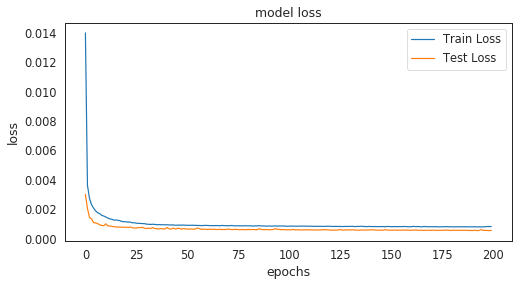

In [21]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

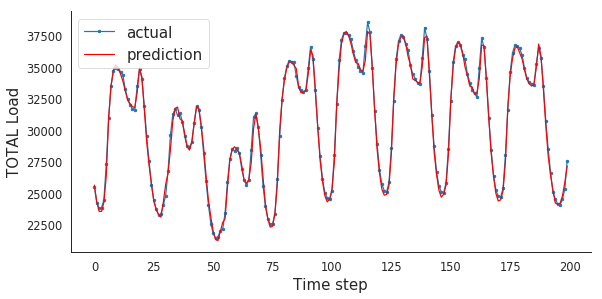

In [22]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

## Analysis and Future Work

The LSTM model preformed close to the forecasted data present in the dataset. The MAPE can be improved further by forming this problem as a multivariate time series and tweaking the LSTM model. There are also many parameters that can improve the overall performance. The rest is upto your imagination!!